## You are going to make a neural network today!

### Imports

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Helper functions

In [55]:
def custom_softmax(x):
    """ 
    Manual softmax function
    """
    exp_logits = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return probs



def load_iris( file_path : str = 'iris.csv' ):
    """
    Load the Iris dataset from a CSV file. Also prints some information about the dataset.
    
    inputs: 
        file_path: path to the CSV file containing the Iris dataset. Default is 'iris.csv', works if the file is in the same directory as this script.
        
    outputs:
        x_data: input features from the dataset
        y_data: output labels from the dataset
    """

    df = pd.read_csv(file_path)  # Assuming a CSV file with input and output data
    x_data = df.iloc[:, :-1].values  # All columns except the last are inputs
  
    x_data = np.hstack((np.ones((x_data.shape[0], 1)), x_data)) # Add a "dummy"-dimension for the bias
    
    y_data = df.iloc[:, -1].values  # Last column is output
    classes = np.unique(y_data) # Keeps only one label per class
    num_classes = len(classes)  # Counts number of unique classes

    # Print some information about the dataset
    print(f"Dataset loaded with {x_data.shape[0]} samples and {x_data.shape[1]} features.")
    print(f"Unique classes in output: {num_classes}")

    for i, c in enumerate(df.columns[:-1]):
        print(f'Feature {i}: "{c}", Range: {df[c].min()} - {df[c].max()}')

    # Convert the string labels to integers
    y_int = np.array(pd.factorize(y_data)[0], dtype = int)
    
    # And to simplify things further on, we convert to one-hot encoding. I.e for each entry, the label will be encoded as a vector with a 1 in the position corresponding to the class, and 0 elsewhere
    y_onehot = np.eye(num_classes)[y_int]


    X, y = x_data, y_onehot
    return X, y



In [56]:
# Load the dataset
X, y = load_iris()


Dataset loaded with 150 samples and 5 features.
Unique classes in output: 3
Feature 0: "sepal_length", Range: 4.3 - 7.9
Feature 1: "sepal_width", Range: 2.0 - 4.4
Feature 2: "petal_length", Range: 1.0 - 6.9
Feature 3: "petal_width", Range: 0.1 - 2.5


### Main Class

In [57]:
class MyNeuralNetwork:
    # We're going to make a simple neural network and investigate how the loss is dependent on the weights, and how to optimize it. 
    def __init__(self, d_inputs, n_outputs):
        """ Initialization function"""
        self.weights = self.create_weights(d_inputs, n_outputs)
        self.best_weights = np.inf*np.ones(self.weights.shape)


    def create_weights(self, d_inputs: int, n_outputs: int):
        """ 
        Randomly initializes the weights of a neural network with the shapes provided.
        * Remember that neural networks typically have a bias term, so the weight matrix should incorporate this. 


        inputs: 
            d_inputs: number of input features
            n_outputs: number of output neurons (in classification, will be equal to the number of classes)

        outputs: 
            weights: randomly initialized weights

        
        """
        
        # TODO: Iniitialize the weights of the network here, random gaussian values with the correct shape.
        
        weights = np.random.rand(d_inputs + 1, n_outputs)
        return weights

    
    def calculate_loss(self, y_true, y_pred):
        """ Calculates the cross entroypy loss between true and predicted values.
        
        inputs: 
            y_true: the true output class
            y_pred: the predicted output class from the network

        outputs: 
            loss: the loss of the networks predictions
        """
        
        # TODO: Implement the cross-entropy loss calculation here.
        eps = 1e-9
        y_pred = np.clip(y_pred, eps, 1 - eps) # avoid log(0.0)
        N = y_true.shape[0]
        loss = - (1/N) * np.sum(y_true * np.log(y_pred))
        return loss
            
    def calculate_accuracy(self, y_true, y_pred):
        """ 
        Calculate the accuracy, the fraction of correct predictions. 
        """
        #TODO: Implement the accuracy function
        prediction = np.argmax(y_pred, axis=1)
        true = np.argmax(y_true, axis=1)
        acc = np.mean(prediction == true)
        return acc
        
        


    def forward_propagation(self, inputs):
        """
        Perform forward propagation through the network. Corresponds to performing the operation y = sigmoid(X*w + b), and then converting the outputs to probabilities by using softmax. But if we're clever, we can include the bias in w and add a dummy dimension to the data (see the load_iris function), and as such we don't need a separate term b for it. 

        inputs: 
            inputs: the data to propagate through the network
        
        outputs: 
            predicted_output: the output of the network from the forward propagation. Equal to the probability the network believes in each class.
        """

        # TODO: Implement the forward propagation here. You can use the softmax function defined above to get the predicted outputs after input has propagated through the network.
        
        predicted_output = custom_softmax(inputs @ self.weights)
        
        return predicted_output
    
    def sweep_of_a_weight(self, i_weight: int, j_weight:int, min_val: float, max_val: float, n_points: int, x_data, y_data):
        """
        Sweep a single weight from min_val to max_val, record and return the loss across the sweep, the best found loss and the best weight.

        inputs: 
            i_weight: index of the weight row to sweep
            j_weight: index of the weight column to sweep
            min_val: minimum value of the weight to sweep
            max_val: maximum value of the weight to sweep
            n_points: number of points in the sweep
            x_data: input data for forward propagation
            y_data: true output data for loss calculation

        outputs: 
            losses: list of losses corresponding to each step in the sweep
            best_loss: the lowest loss found during the sweep
            best_weight: the weight value that resulted in the lowest loss
        """

        # TODO: Implement the weight sweep here. Note that you should not update the weights here,  so keep track of the original weight value and reset it after your sweep has been concluded.
        # save original sweeped weights
        original_sweeped_weight = self.weights[i_weight, j_weight]
        # set the range of weight
        value_range = np.linspace(min_val, max_val, n_points)
        # save loss
        losses = []
        best_loss = np.inf
        for value in value_range:
            self.weights[i_weight, j_weight] = value
            y_pred = self.forward_propagation(x_data)
            loss = self.calculate_loss(y_data, y_pred)
            losses.append(loss)

        if loss < best_loss:
            best_loss = loss
            best_weight = value

        self.weights[i_weight, j_weight] = original_sweeped_weight
        return losses, best_loss, best_weight
    
    def update_weights_backprop(self, X, y, y_pred):
        """
        Update the weights of the network using backpropagation.

        inputs: 
            learning_rate: the learning rate for weight updates
            x_data: input data for forward propagation
            y_data: true output data for loss calculation
        """

        learning_rate = 0.1 # Learning rate (eta in literature) Don't need to change this value here, but you can experiment with it later if you want to.


        # TODO: Compute the gradient
        gradient = X.T @ (y_pred - y) / X.shape[0]


        # Update weights
        self.weights = self.weights - learning_rate * gradient


# Investigation of loss


In [58]:
# Create your first network
np.random.seed(123)

nn_sweep = MyNeuralNetwork(4, 3)


Best weight value found for weight w[3,2] was: 10.00


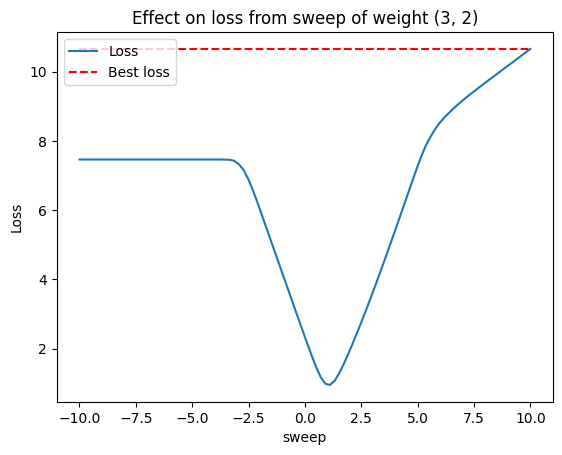

In [59]:
# This function will plot the dependency of one weight, how the loss changes as it goes from min_val to max_val. Also shows where the best value was found.

def plot_dependency_on_one_weight(nn, i_weight, j_weight, min_val, max_val, n_sweeping_points, X, y):

    losses, best_loss, best_weight = nn.sweep_of_a_weight(i_weight, j_weight, min_val, max_val, n_sweeping_points, X, y)
    x_axis = np.linspace(min_val, max_val, n_sweeping_points)
    plt.plot(x_axis, losses, label = 'Loss')
    plt.title("Effect on loss from sweep of weight ({}, {})".format(i_weight, j_weight))
    plt.hlines(best_loss, min_val, max_val, label = 'Best loss', color = 'red', linestyles='dashed')
    print(f"Best weight value found for weight w[{i_weight},{j_weight}] was: {best_weight:.2f}")
    plt.legend()
    plt.xlabel('sweep')
    plt.ylabel('Loss')
    plt.show()


plot_dependency_on_one_weight(nn_sweep, 3,2, -10, 10, 100, X, y)



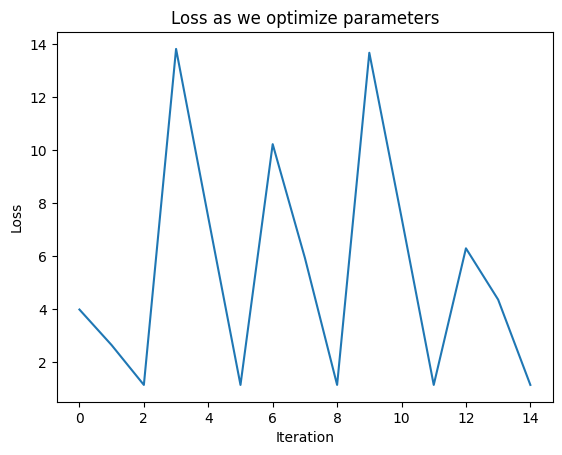

Accuracy after update step is finished: 0.33


In [60]:
# This function performs a sweep over all weights centered around the current value, and updates the weights based on the optimal weights.

def sequential_weight_optimization(nn, search_width, n_sweeping_points, X, y, plot = True):
    r, c = nn.weights.shape
    best_loss_history = []
    for i in range(r):
        for j in range(c):
            current_weight_value = nn.weights[i,j]
            _, current_best_loss, current_best_weight  = nn.sweep_of_a_weight(i, j, current_weight_value - search_width, current_weight_value +search_width, n_sweeping_points, X, y)
            nn.weights[i, j] = current_best_weight
            best_loss_history.append(current_best_loss)
    
    if plot:
        plt.plot(best_loss_history)
        plt.title("Loss as we optimize parameters")
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()

sequential_weight_optimization(nn_sweep, 5, 1000, X, y)
print(f"Accuracy after update step is finished: {nn_sweep.calculate_accuracy(y, nn_sweep.forward_propagation(X)):.2f}")


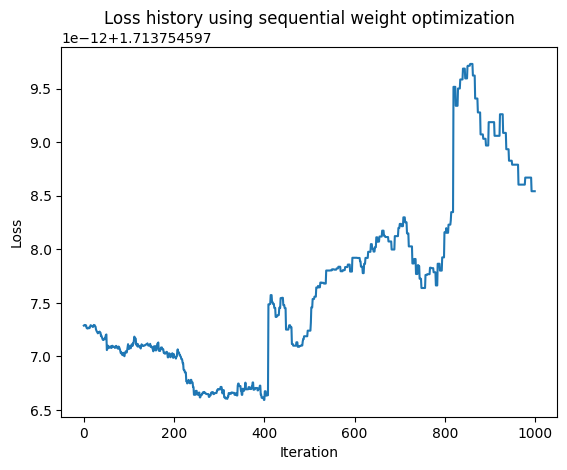

Final loss after 1000 sequential weight optimizations: 1.7138
Final accuracy: 0.33


In [61]:
# Now we'll want to do multiple runs, which will iteratively improve the weights.

nn_sweep.weights = nn_sweep.create_weights(4,3) # Reinitialize the weights
loss_history = []
for i in range(1000):
    sequential_weight_optimization(nn_sweep, 5, 100, X, y, plot = False)
    nn_sweep.calculate_loss(y, nn_sweep.forward_propagation(X))
    loss = nn_sweep.calculate_loss(y, nn_sweep.forward_propagation(X))
    loss_history.append(loss)
plt.plot(loss_history)
plt.title("Loss history using sequential weight optimization")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

nn_sweep_output = nn_sweep.forward_propagation(X)
print(f"Final loss after 1000 sequential weight optimizations: {nn_sweep.calculate_loss(y, nn_sweep_output):.4f}")
print(f"Final accuracy: {nn_sweep.calculate_accuracy(y,nn_sweep_output):.2f}")



## Now we're going to see how to use backpropagation instead!

Go back to the class and write update method for the backward propagation. 

Then run the cells below to generate a figure of your performance.

Final loss after 1000 backpropagation steps: 0.1253
Final accuracy: 0.99


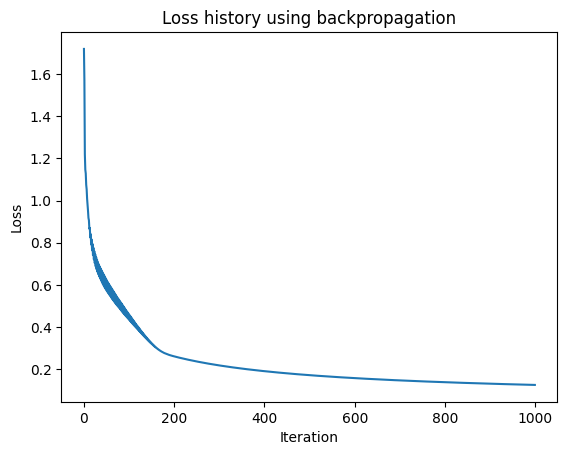

In [62]:
nn_backprop = MyNeuralNetwork(4, 3)
loss_history = []
for i in range(1000):
    y_pred = nn_backprop.forward_propagation(X)
    nn_backprop.update_weights_backprop(X, y, y_pred)
    loss = nn_backprop.calculate_loss(y, y_pred)
    loss_history.append(loss)

  

print(f"Final loss after 1000 backpropagation steps: {loss_history[-1]:.4f}") 
print(f"Final accuracy: {nn_backprop.calculate_accuracy(y, nn_backprop.forward_propagation(X)):.2f}")
plt.plot(loss_history)
plt.title("Loss history using backpropagation")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


# Do it in Pytorch

In [63]:
import torch
import torch.nn as nn

In [64]:
# Converting the data to torch tensors, which are the datatyp needed for torch to function
# Note: We'll remove the first column of ones, as torch's linear layer includes a bias term by default.
X_tensor = torch.tensor(X[:,1:], dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
y_tensor = torch.max(y_tensor, 1)[1]  # Convert to class indices for CrossEntropyLoss
print(X_tensor.dtype, y_tensor.dtype)
print(X_tensor.shape, y_tensor.shape)

torch.float32 torch.int64
torch.Size([150, 4]) torch.Size([150])


In [65]:
# Defining a simple neural network model using PyTorch
class SimpleNN(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        # Here we define a linear layer that includes both weights and bias
        self.linear_layer = torch.nn.Linear(input_size, output_size)
        
    def forward(self, x):
        x = self.linear_layer(x)
        return x

In [66]:
# Also here's a simple accuracy function here for later use: 

def accuracy(y_pred_classes, y_true):
    """
    y_pred_classes: tensor of shape (N,) containing predicted class indices
    y_true: tensor of shape (N,) containing true class indices
    """
    correct = (y_pred_classes == y_true).sum().item()
    total = y_true.size(0)
    return correct / total

In [67]:
# Make an instance of the model
model = SimpleNN(input_size=4, output_size=3)  # 4 input features, 3 output classes


In [68]:
# Defining the loss function 
loss_function = torch.nn.CrossEntropyLoss() # Define the loss function, the same as you did before!
outputs = model(X_tensor)  # Forward pass through the model, also what you did before

loss = loss_function(outputs, y_tensor)  # Calculate loss

In [69]:
loss.backward()  # .backward() this is the absolute key line that computes the gradient. If you've defined your model and loss function correctly, PyTorch will automatically compute the gradients for all parameters in the model. The model needs to be differentiable for this to work, so if you sometime in the future are working with other things, keep this in mind. 

In [70]:
# Now we can simply access them via the .grad attribute of each parameter.
print("Weight gradient: ")
print(model.linear_layer.weight.grad)

print("Bias gradient: ")
print(model.linear_layer.bias.grad)

Weight gradient: 
tensor([[ 1.1992,  0.3206,  1.4381,  0.5448],
        [-1.8707, -0.8666, -1.3501, -0.4198],
        [ 0.6715,  0.5460, -0.0881, -0.1250]])
Bias gradient: 
tensor([ 0.1502, -0.3144,  0.1641])


In [71]:
# We can see our current weights and biases: 
print("Weights before update: ")
print(model.linear_layer.weight)
print("Bias before update: ")
print(model.linear_layer.bias)

Weights before update: 
Parameter containing:
tensor([[ 0.4622,  0.2633, -0.4704, -0.1656],
        [-0.3568,  0.3985, -0.1004, -0.4682],
        [ 0.3969,  0.4998, -0.4625, -0.4060]], requires_grad=True)
Bias before update: 
Parameter containing:
tensor([ 0.0093,  0.0781, -0.0429], requires_grad=True)


In [72]:
# To perform a simple update step manually, you can do the following:
learning_rate = 0.1
with torch.no_grad():  # We use this context manager to tell PyTorch that we don't want to track gradients during this operation. Not necessary if using optimizer.step(), which we'll do later.
    for param in model.parameters():
        param = param - learning_rate* param.grad  # Update each parameter by subtracting the gradient of it

In [73]:
# And if we look at the weights and biases again, we can see that they have been updated:
print("Weights after manual update: ")
print(model.linear_layer.weight)
print("Bias after manual update: ")
print(model.linear_layer.bias)

Weights after manual update: 
Parameter containing:
tensor([[ 0.4622,  0.2633, -0.4704, -0.1656],
        [-0.3568,  0.3985, -0.1004, -0.4682],
        [ 0.3969,  0.4998, -0.4625, -0.4060]], requires_grad=True)
Bias after manual update: 
Parameter containing:
tensor([ 0.0093,  0.0781, -0.0429], requires_grad=True)


In [74]:
# Now, there's a easier way to do this using a torch optimizer. Instead of manually updating the weights as above, you can simply define an optimizer, and call it to perform an update step. Remember, we're optimizing the parameters of the model based on the loss.

optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # Defining the opitmizer to use. This will update the weights based on the gradients computed during loss.backward()


Final loss after 1000 PyTorch optimization steps: 0.1248
Final accuracy: 0.99


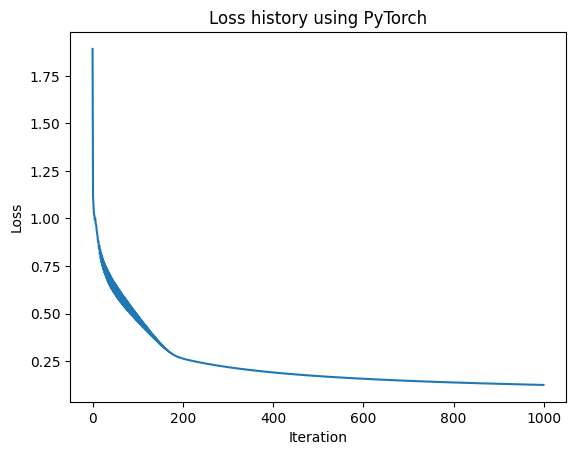

In [75]:
# Now, we can put all of this together. A standard training loop using the optimizer would look like this:
loss_history = []
for epoch in range(1000):
    optimizer.zero_grad()  # Zero the gradients (We don't want to accumulate gradients from previous steps, which is the default behavior in PyTorch)

    outputs = model(X_tensor)  # Forward pass through the model

    loss = loss_function(outputs, y_tensor)  # Compute loss

    loss.backward()  # Backward pass (compute gradients)
    optimizer.step()  # Update weights
    
    loss_history.append(loss.item()) # Save the loss per epoch

print(f"Final loss after 1000 PyTorch optimization steps: {loss_history[-1]:.4f}")
print(f"Final accuracy: {accuracy(torch.argmax(model(X_tensor), dim = 1), y_tensor):.2f}")

plt.plot(loss_history)
plt.title("Loss history using PyTorch")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [76]:
# Comparison of the optimal weights found from your three neural network implementations
print(" Pytorch optimal weights:")
torch_weights = torch.concat([torch.unsqueeze(model.linear_layer.bias, dim = 1) ,model.linear_layer.weight ], dim = 1).detach().numpy()
print(torch_weights)
print()

print("Linear sweep optimal weights")
print(nn_sweep.weights.T)
print()

print("First neural network optimal weights")
print(nn_backprop.weights.T)


 Pytorch optimal weights:
[[ 0.40713072  1.2056729   2.2808933  -3.31518    -1.4984459 ]
 [ 0.79189014  0.7515959   0.30585155 -0.3399059  -1.6477841 ]
 [-1.1545008  -1.4550223  -1.4251089   2.6218162   2.106464  ]]

Linear sweep optimal weights
[[5000.73799541 5000.53155137 5000.84943179 5000.72244338 5000.22826323]
 [5000.18249173 5000.53182759 5000.72445532 5000.32295891 5000.29371405]
 [5000.17545176 5000.63440096 5000.61102351 5000.36178866 5000.63097612]]

First neural network optimal weights
[[ 0.54306856  1.45213267  2.64104949 -2.38509195 -1.02217949]
 [ 1.07256075  1.02657711  0.65177354  0.34570544 -0.62476366]
 [-0.65896044 -1.24693317 -1.02892255  3.28079453  3.245364  ]]


In [77]:
class SecondModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(SecondModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        # TODO: Add your own layers here
        self.hidden1 = nn.Linear(input_size, 16)
        self.hidden2 = nn.Linear(16, 8)
        self.output_layer = nn.Linear(8, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        #TODO: Define the forward pass through your layers here.
        # fist hidden layer with activation functions
        x = self.activation(self.hidden1(x))
        # second hidden layer with activation functions
        x = self.activation(self.hidden2(x))
        # output layer
        x = self.output_layer(x)
        return x



In [78]:
# Then we can run through the training loop again
model2 = SecondModel(4, 3)  # 4 input features, 3 output classes
# Defining the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

# Training loop
loss_history = []
for epoch in range(1000):
    optimizer.zero_grad()  # Zero the gradients
    outputs = model(X_tensor)  # Forward pass
    loss = loss_function(outputs, torch.max(y_tensor, 1)[1])  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    loss_history.append(loss.item())


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)